<a href="https://colab.research.google.com/github/ramyamahesh1126/Assignments/blob/Assignment2/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [3]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [4]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features) 


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


### Attention Mechanism

![title](AttentionMechanism.png)

In [5]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [6]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

![title](a_input.png)

In [7]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [8]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


### Masked Attention

In [9]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [10]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[1, 0, 1],
        [1, 1, 0],
        [1, 0, 0]]) 
 tensor([[-0.3162, -0.2139, -0.3891],
        [-0.2325, -0.1302, -0.3054],
        [-0.3841, -0.2819, -0.4570]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-3.1620e-01, -9.0000e+15, -3.8907e-01],
        [-2.3250e-01, -1.3023e-01, -9.0000e+15],
        [-3.8415e-01, -9.0000e+15, -9.0000e+15]], grad_fn=<SWhereBackward0>)

In [11]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [12]:
attention

tensor([[0.5182, 0.0000, 0.4818],
        [0.4745, 0.5255, 0.0000],
        [1.0000, 0.0000, 0.0000]], grad_fn=<SoftmaxBackward0>)

In [13]:
h_prime

tensor([[-0.1948,  1.4558],
        [-0.3612,  1.1771],
        [-0.2504,  1.3240]], grad_fn=<MmBackward0>)

#### h_prime vs h

In [14]:
print(h_prime,"\n",h)

tensor([[-0.1948,  1.4558],
        [-0.3612,  1.1771],
        [-0.2504,  1.3240]], grad_fn=<MmBackward0>) 
 tensor([[-0.2504,  1.3240],
        [-0.4613,  1.0445],
        [-0.1351,  1.5975]], grad_fn=<MmBackward0>)


# Build the layer

In [15]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        
        '''
        TODO
        '''
        
    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [16]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

In [17]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [18]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

tensor(1.9487, grad_fn=<NllLossBackward0>)
tensor(0.7113, grad_fn=<NllLossBackward0>)
tensor(0.6750, grad_fn=<NllLossBackward0>)
tensor(0.6297, grad_fn=<NllLossBackward0>)
tensor(0.6121, grad_fn=<NllLossBackward0>)


In [19]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8260


## EDGE PREDICTION

In [20]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [21]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [22]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [23]:
# load the Cora dataset
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [24]:
# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [25]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [26]:

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [27]:

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


In [28]:

best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))



Epoch: 010, Loss: 0.6776, Val: 0.6744, Test: 0.6798
Epoch: 020, Loss: 0.6187, Val: 0.7385, Test: 0.7611
Epoch: 030, Loss: 0.5407, Val: 0.7768, Test: 0.7876
Epoch: 040, Loss: 0.5033, Val: 0.8256, Test: 0.8328
Epoch: 050, Loss: 0.4646, Val: 0.8617, Test: 0.8702
Epoch: 060, Loss: 0.4631, Val: 0.8681, Test: 0.8732
Epoch: 070, Loss: 0.4588, Val: 0.8814, Test: 0.8842
Epoch: 080, Loss: 0.4495, Val: 0.8919, Test: 0.8912
Epoch: 090, Loss: 0.4454, Val: 0.8988, Test: 0.8942
Epoch: 100, Loss: 0.4382, Val: 0.9014, Test: 0.8964


In [29]:
z = model.encode()
final_edge_index = model.decode_all(z)

## NODE PREDICTION

In [30]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [31]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
dataset = "AIDS"
data = TUDataset(".", name=dataset)

In [33]:
print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)

AIDS(2000)
number of classes:  2 		(active),(inactive)
number of features:  38
number of edge labels:  3


In [34]:
data1 = data[1]

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [35]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [36]:
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])
    
print(graph1.edges(data=True))

[(0, 1, {'label': array([1., 0., 0.], dtype=float32)}), (0, 5, {'label': array([1., 0., 0.], dtype=float32)}), (1, 2, {'label': array([1., 0., 0.], dtype=float32)}), (1, 6, {'label': array([0., 1., 0.], dtype=float32)}), (5, 4, {'label': array([1., 0., 0.], dtype=float32)}), (5, 8, {'label': array([1., 0., 0.], dtype=float32)}), (2, 3, {'label': array([1., 0., 0.], dtype=float32)}), (3, 4, {'label': array([1., 0., 0.], dtype=float32)}), (3, 7, {'label': array([0., 1., 0.], dtype=float32)}), (4, 9, {'label': array([1., 0., 0.], dtype=float32)}), (4, 10, {'label': array([1., 0., 0.], dtype=float32)})]


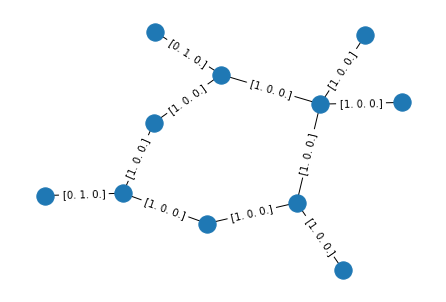

In [37]:
pos = nx.spring_layout(graph1)
nx.draw(graph1,pos)
nx.draw_networkx_edge_labels(graph1,pos,nx.get_edge_attributes(graph1,'label'))
plt.show()

In [38]:
data.data

Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [39]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

In [40]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [41]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [42]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

53 11 12
True
train set	 [68 26 21  3 44 41  6 20  2 60]
test set 	 [13 73 51 49 14 67 70 33 58 43]
val set  	 [54 11 16 36 40  0  8 29 28 64]


In [43]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
val mask   	 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])


In [44]:
# remove from the data what do we not use.

print("befor\t\t",data)
data.x = None
data.edge_attr = None
data.y = None

befor		 Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [45]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print("after\t\t",data)

after		 Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


In [51]:
!pip install torch-cluster

  Using cached torch_cluster-1.6.0.tar.gz (43 kB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.7/contextlib.py", line 524, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/temp_dir.py", line 75, in tempdir_registry
    yield _tempdir_registry
  File "/usr/

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

In [ ]:
z = model()

### visualize node embedding

In [53]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

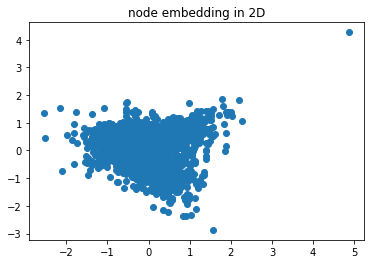

In [54]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

In [55]:
# reload AIDS dataset 
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [56]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Numerical edge attributes:
 [0, 0, 1]


In [57]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))

### visualize edge embedding


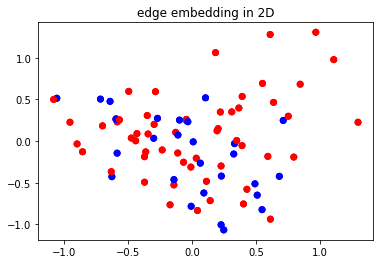

In [58]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [60]:
clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(clf, edge_embedding, edge_attr, cv=10)
np.mean(scores)

0.663235294117647